In [3]:

# from polytropic_stars.EOSPath import EOSPath
from EOSGenerator import EOSGenerator
import matplotlib.pyplot as plt
import random
from CRUST import CRUST
import numpy as np
from scipy.integrate import solve_ivp
import random
import csv
import os 
from EOS import EOS
# TOV right-hand side equations

# TOV right-hand side equations
def tov_rhs(r, z, eos_object, P_saturation):
    M, P = z

    if P <= 0:
        return [0, 0]

    if P > P_saturation:
        epsilon = eos_object.energy_density_from_pressure(P)

    elif 0.184 <= P <= P_saturation:
        e = EOS(P)
        epsilon = e.HLPS_2()

    else:
        crust = CRUST(P)
        epsilon = crust.equation()

    dM_dr = 11.2e-6 * r**2 * epsilon
    dP_dr = -1.474 * (epsilon * M / r**2) * (1 + P / epsilon) * (1 + 11.2e-6 * r**3 * P / M) * (1 - 2.948 * M / r)**(-1)

    return [dM_dr, dP_dr]


# Stopping event when pressure becomes tiny
def stop_when_pressure_small(r, y):
    return y[1] - 1e-10  # Stop when P ~ 0
stop_when_pressure_small.terminal = True
stop_when_pressure_small.direction = -1

# Solve a single TOV star
def solve_star(P_central, eos_object):
    
    z0 = [1e-12, P_central]  # Initial [M, P]
    r_span = (1e-9, 2e6)     # Integrate from tiny radius up to big radius
    sol = solve_ivp(lambda r, z: tov_rhs(r, z, eos_object, 1.722),
                    r_span, 
                    z0,
                    method='RK45',
                    atol=1e-10,
                    rtol=1e-8,
                    events=[stop_when_pressure_small],
                    max_step=0.1)
    return sol

# Process one EOS model
def process_model(model_name, eos_object, initial_pressures):
    results = []

    for i, P_center in enumerate(initial_pressures):
        sol = solve_star(P_center, eos_object)

        if sol.status == 1:  # event triggered (good convergence)
            R_star = sol.t_events[0][0]  # surface radius
            M_star = sol.y_events[0][0][0]  # final mass
            results.append((M_star, R_star, P_center))
            print(f"Model:{model_name} | Mass:{M_star:.4f} | Radius:{R_star:.4f} | Pc={P_center:.2f}")
        else:
            print(f"Warning: Model {model_name} Pc={P_center:.2f} did not converge.")

    return model_name, results

# MAIN EXECUTION
if __name__ == "__main__":
    # Create folder for results
    os.makedirs('TOV_results', exist_ok=True)

    # Generate EOS models
    p_sat = 1.722  # MeV/fm³
    e = EOS(p_sat)
    initial_rho = e.HLPS_2()  # fm⁻³
    segments = 4
    gamma_options = [1, 5]

    generator = EOSGenerator(p_saturation=p_sat, initial_density=initial_rho, segments=segments, gamma_options=gamma_options)
    generator.generate()
    eos_models = generator.get_models()

    # Define central pressures
    ic1 = np.arange(1.5, 5, 0.1)
    ic2 = np.arange(5, 1200, 1)
    initial_pressures = np.concatenate((ic1, ic2), axis=None)

    # Solve for all EOS models
    for eos_model in eos_models:
        model_name = eos_model.name
        eos_object = eos_model

        model_name, model_results = process_model(model_name, eos_object, initial_pressures)

        # Save results
    with open(f"TOV_results/{model_name}_TOV.csv", "w", newline="") as f:
        write_obj = csv.writer(f)
        write_obj.writerow(["Mass", "Radius", "Pressure", "Type"])
        for m, r, p in model_results:
            write_obj.writerow([m, r, p, 0])

Model:EOS_0 | Mass:0.7217 | Radius:2375.8676 | Pc=1.50
Model:EOS_0 | Mass:0.2124 | Radius:2262.3662 | Pc=1.60
Model:EOS_0 | Mass:0.0595 | Radius:142.0360 | Pc=1.70
Model:EOS_0 | Mass:0.0620 | Radius:66.4639 | Pc=1.80
Model:EOS_0 | Mass:0.0651 | Radius:44.9093 | Pc=1.90
Model:EOS_0 | Mass:0.0682 | Radius:34.8975 | Pc=2.00
Model:EOS_0 | Mass:0.0713 | Radius:29.4048 | Pc=2.10
Model:EOS_0 | Mass:0.0740 | Radius:26.1162 | Pc=2.20
Model:EOS_0 | Mass:0.0764 | Radius:23.9282 | Pc=2.30
Model:EOS_0 | Mass:0.0785 | Radius:22.3435 | Pc=2.40
Model:EOS_0 | Mass:0.0805 | Radius:21.1523 | Pc=2.50
Model:EOS_0 | Mass:0.0822 | Radius:20.1899 | Pc=2.60
Model:EOS_0 | Mass:0.0838 | Radius:19.4747 | Pc=2.70
Model:EOS_0 | Mass:0.0852 | Radius:18.8527 | Pc=2.80
Model:EOS_0 | Mass:0.0865 | Radius:18.3386 | Pc=2.90
Model:EOS_0 | Mass:0.0877 | Radius:17.8936 | Pc=3.00
Model:EOS_0 | Mass:0.0887 | Radius:17.5129 | Pc=3.10
Model:EOS_0 | Mass:0.0897 | Radius:17.1765 | Pc=3.20
Model:EOS_0 | Mass:0.0906 | Radius:16.891

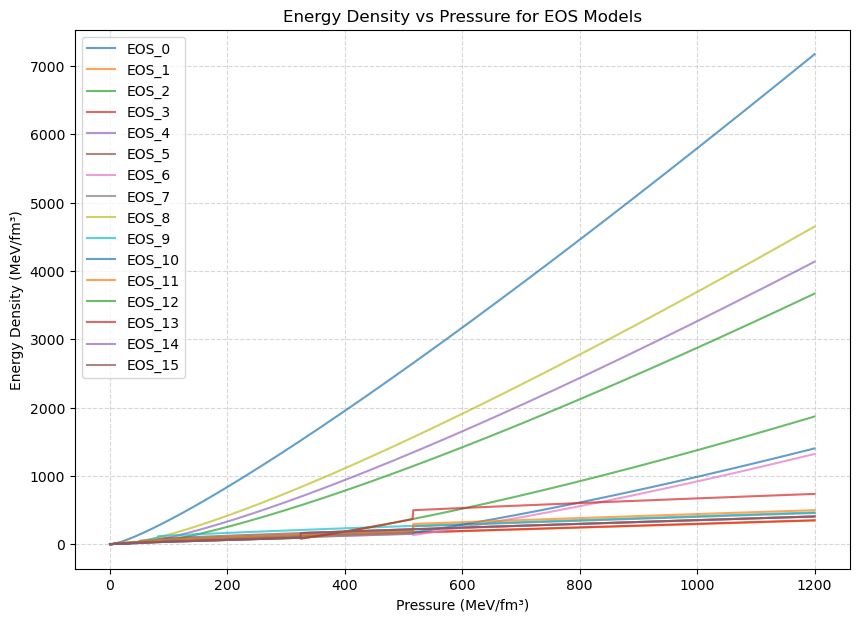

In [ ]:
plt.figure(figsize=(10, 7))

# Plot HLPS_2 EOS
plt.plot(p, e1, label="HLPS_2", linewidth=2)

# Plot energy_density_from_pressure for each model
for model in eos_models:
    energy_density = [model.energy_density_from_pressure(pressure) for pressure in p]
    plt.plot(p, energy_density, label=model.name, alpha=0.7)

plt.xlabel("Pressure (MeV/fm³)")
plt.ylabel("Energy Density (MeV/fm³)")
plt.title("Energy Density vs Pressure for EOS Models")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
C:\Users\vasil\AppData\Local\Temp\ipykernel_13032\3207377124.py:21: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass (M$_\odot$)")


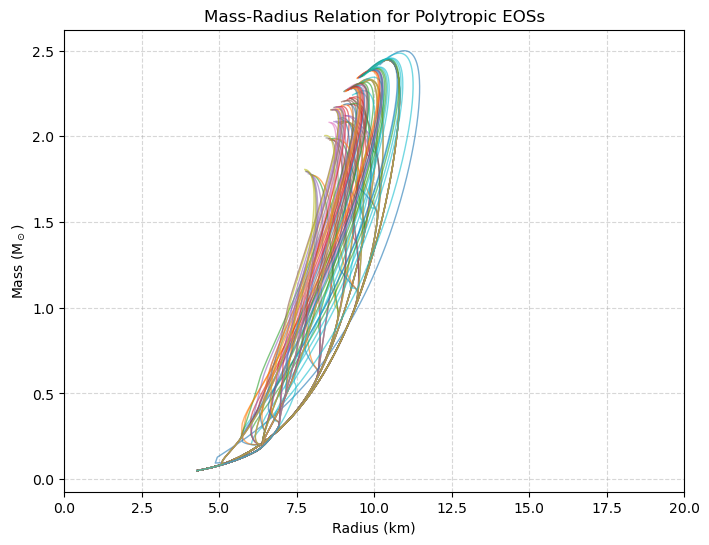

In [1]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files[100:200]:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(0, 20)
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
C:\Users\vasil\AppData\Local\Temp\ipykernel_10780\3765803306.py:21: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass (M$_\odot$)")


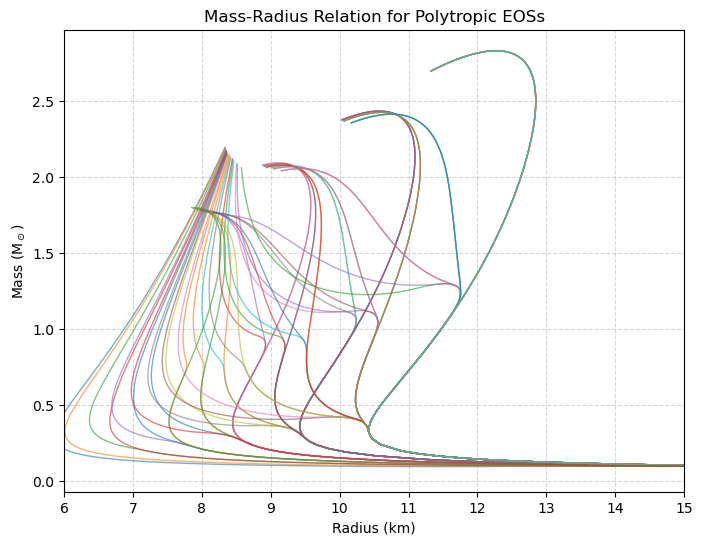

In [10]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(6, 15)
plt.show()


[]